<a href="https://colab.research.google.com/github/adityasahu88/DL_PROJECTS/blob/main/DOG_BREED_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project, we will see how to use Keras and TensorFlow to build, train, and test a Convolutional Neural Network capable of identifying the breed of a dog in a supplied image. This is a supervised learning problem, specifically a multiclass classification problem.

In [1]:
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle


In [2]:
!kaggle datasets download catherinehorng/dogbreedidfromcomp

Dataset URL: https://www.kaggle.com/datasets/catherinehorng/dogbreedidfromcomp
License(s): unknown
 99% 681M/691M [00:07<00:00, 114MB/s]
100% 691M/691M [00:07<00:00, 101MB/s]


In [3]:
!unzip -q dogbreedidfromcomp.zip

In [4]:
!rm sample_submission.csv
!rm dogbreedidfromcomp.zip

In [5]:
# import multiple library
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


In [6]:
# import the labels.csv to the dataaframe
df_labels =pd.read_csv("labels.csv")
df_labels['id']= df_labels['id']+".jpg"
df_labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


In [7]:
df_labels.shape

(10222, 2)

Loading the labels data into dataframe and viewing it. Here we analysed that labels contains 10222 rows and 2 columns.  

In [8]:
df_labels['breed'].value_counts()

,count
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
...,...
golden_retriever,67
brabancon_griffon,67
komondor,67


- here we observed that class imbalance is avaiable because the count of each breed is not same

In [9]:
# lets use the VGG16
base_model =tf.keras.applications.VGG16(include_top=False,
                                        input_shape=(150,150,3))
base_model.trainable=False
base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
idg = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.1,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

In [11]:
batch_size =32

In [12]:
train_idg = idg.flow_from_dataframe(df_labels,
                                    directory="train/",
                                    x_col="id",
                                    y_col="breed",
                                    target_size=(150,150),  # Corrected target size
                                    subset="training",
                                    batch_size=batch_size)  # Use only if validation_split is defined

Found 9200 validated image filenames belonging to 120 classes.


In [13]:
val_idg = idg.flow_from_dataframe(df_labels,
                                    directory="train/",
                                    x_col="id",
                                    y_col="breed",
                                    target_size=(150,150),  # Corrected target size
                                    subset="validation",
                                     batch_size=batch_size)  # Use only if validation_split is defined

Found 1022 validated image filenames belonging to 120 classes.


In [14]:
# Create the model from the flatten layers
flat =   tf.keras.layers.Flatten() ((base_model.output))
dense1 = tf.keras.layers.Dense(512,activation=tf.keras.activations.relu) (flat)
dense2 = tf.keras.layers.Dense(256,activation=tf.keras.activations.relu) (dense1)
dense3 = tf.keras.layers.Dense(128,activation=tf.keras.activations.relu) (dense2)
dense4 = tf.keras.layers.Dense(64,activation=tf.keras.activations.relu) (dense3)
output = tf.keras.layers.Dense(120,activation=tf.keras.activations.softmax) (dense4)

final_model= tf.keras.models.Model(inputs = base_model.input,outputs=output)
final_model.summary()




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 19,089,784 (72.82 MB)

 Trainable params: 4,375,096 (16.69 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

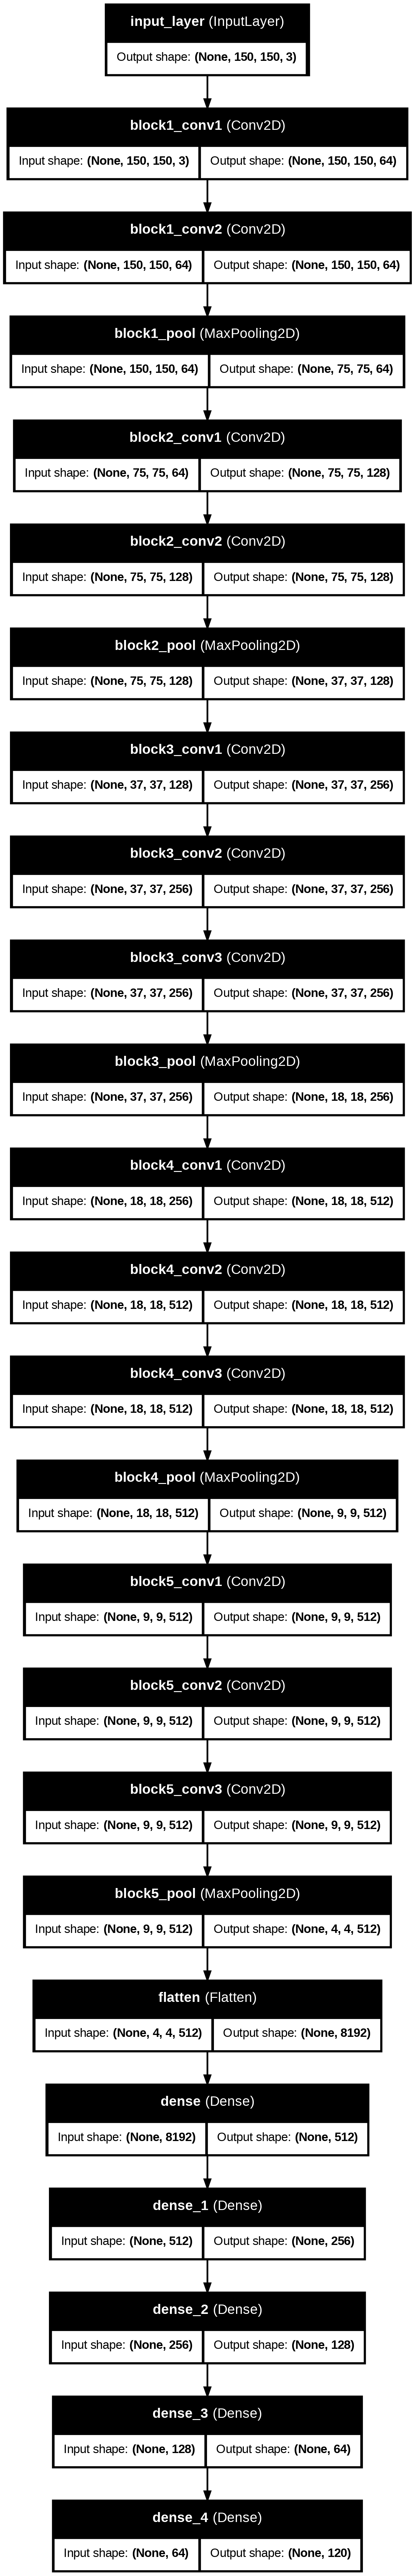

In [15]:
# plot the model
tf.keras.utils.plot_model(final_model,show_shapes=True,show_layer_names=True)

In [16]:
# compile the model
final_model.compile(optimizer =tf.keras.optimizers.SGD(),
                    loss = tf.keras.losses.categorical_crossentropy,
                    metrics=["accuracy"])

In [17]:
# fit the model
final_model.fit(train_idg,batch_size =batch_size,epochs=10,validation_data=val_idg)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 58s 167ms/step - accuracy: 0.0124 - loss: 8.6281 - val_accuracy: 0.0313 - val_loss: 4.6966
Epoch 2/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 35s 121ms/step - accuracy: 0.0496 - loss: 4.5508 - val_accuracy: 0.0822 - val_loss: 4.3014
Epoch 3/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 34s 117ms/step - accuracy: 0.1370 - loss: 3.9119 - val_accuracy: 0.1810 - val_loss: 3.6168
Epoch 4/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 34s 119ms/step - accuracy: 0.2961 - loss: 2.9412 - val_accuracy: 0.2642 - val_loss: 3.0896
Epoch 5/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 34s 119ms/step - accuracy: 0.4313 - loss: 2.1703 - val_accuracy: 0.3268 - val_loss: 2.7439
Epoch 6/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 36s 125ms/step - accuracy: 0.5581 - loss: 1.6128 - val_accuracy: 0.3718 - val_loss: 2.6641
Epoch 7/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 39s 119ms/step - accuracy: 0.6499 - loss: 1.2127 - val_accuracy: 0.3679 - val_loss: 2.7887
Epoch 8/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 36s 123ms/step - accuracy: 0.7281 - loss: 0

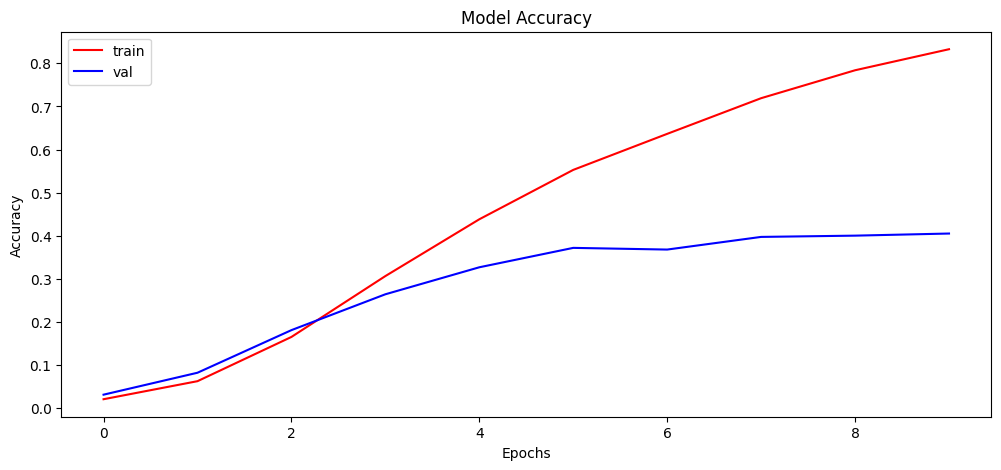

In [19]:
# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(final_model.history.history['accuracy'], color='r')
plt.plot(final_model.history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

- If validation accuracy is much lower than training accuracy, your model is not generalizing well.
- It indicates model is overfitting

**Why Is Overfitting Happening?**

1️⃣ Too Complex Model
- The model has too many parameters and captures unnecessary noise.

2️⃣ Not Enough Training Data

- If the dataset is small, the model memorizes rather than generalizing.

3️⃣ Lack of Data Augmentation

- If images are not varied enough (rotations, flips, brightness changes, etc.), the model may struggle with unseen variations.

4️⃣ Improper Regularization

- No Dropout, L2 Regularization, or Batch Normalization to prevent overfitting.

In [20]:
train_idg.class_indices

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'